In [128]:
import os
import math
import pickle
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
import xgboost

from torch.utils.data import DataLoader, TensorDataset

from utils.weather_api import WeatherApi
from utils.common_function import splitData
from enums.enums import Model, Date, Data, Rmse
from sklearn.metrics import accuracy_score

weatherApi = WeatherApi();
area = 'Swanton_OH'
# Swanton_OH
X, y = weatherApi.get_weather_data_from_excel(area)
X_train, X_test, y_train, y_test = splitData(X, y, 365)

# MinMaxScaler 적용
scaler = MinMaxScaler()
if 'date' in X_train.columns:
    X_train = X_train.drop(columns=['date'])
    X_test = X_test.drop(columns=['date'])
if 'date' in y_train.columns[0]:
    y_train = y_train.drop(columns=[y_train.columns[0]])
    y_test = y_test.drop(columns=[y_test.columns[0]])

# MinMaxScaler 적용
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

date_range = pd.date_range(start='2023-08-01', end='2024-07-30')
date_df = pd.DataFrame(date_range, columns=['date'])


In [129]:
with open('result_model_fold/Swanton_OH/MLP_model_with_Swanton_OH.pkl', 'rb') as f:
    mlp = pickle.load(f)
mlp_model = mlp[Model.MODEL]

with open('result_model_fold/Swanton_OH/RF_model_with_Swanton_OH.pkl', 'rb') as f:
    rf = pickle.load(f)
rf_model = rf[Model.MODEL]

with open('result_model_fold/Swanton_OH/ExtraTree_model_with_Swanton_OH.pkl', 'rb') as f:
    extra = pickle.load(f)
extra_model = extra[Model.MODEL]

with open('result_model_fold/Swanton_OH/DecisionTree_model_with_Swanton_OH.pkl', 'rb') as f:
    decision = pickle.load(f)
decision_model = decision[Model.MODEL]

with open('result_model_fold/Swanton_OH/GradientBoosting_model_with_Swanton_OH.pkl', 'rb') as f:
    gradient = pickle.load(f)
gradient_model = gradient[Model.MODEL]

with open('result_model_fold/Swanton_OH/Xgboost_model_with_Swanton_OH.pkl', 'rb') as f:
    xgboost_ = pickle.load(f)
xgboost_model = xgboost_[Model.MODEL]

In [130]:
gradient_ml_model = MultiOutputRegressor(gradient_model)
# Voting Regressor 생성
voting_reg = VotingRegressor(estimators=[
        # ('random_forest', rf_model),
        # ('extra', extra_model),
        # ('mlp', mlp_model),
        ('decision', decision_model),
        # ('gradient', gradient_ml_model),
        ('xgboost', xgboost_model)
    ]
)
# MultiOutputRegressor로 다중 출력 회귀 처리
multi_output_voting_reg = MultiOutputRegressor(voting_reg)
multi_output_voting_reg.fit(X_train_scaled, y_train)
y_pred = multi_output_voting_reg.predict(X_test_scaled)

data_to_save = {
    Model.MODEL: multi_output_voting_reg,
    Data.TRAIN_INPUT_DATA: X_train_scaled,
    Data.TRAIN_OUTPUT_DATA: X_test_scaled,
    Data.VALID_INPUT_DATA: [],
    Data.VALID_OUTPUT_DATA: [],
    Data.TEST_INPUT_DATA: X_test_scaled,
    Data.TEST_OUTPUT_DATA: y_test,
    Data.PREDICTED_OUTPUT_DATA: y_pred,
    Rmse.BEST_RMSE: math.sqrt(mean_squared_error(y_pred, y_test)),
    Date.DATE: date_df,
}

In [131]:
data_to_save[Rmse.BEST_RMSE]

3.2333733015063144

In [132]:
path = f'result_model_fold/{area}'
file_path = f'{path}/Voting_XG_DT_model_with_{area}.pkl'

os.makedirs(path, exist_ok=True)
with open(file_path, 'wb') as f:
    pickle.dump(data_to_save, f)

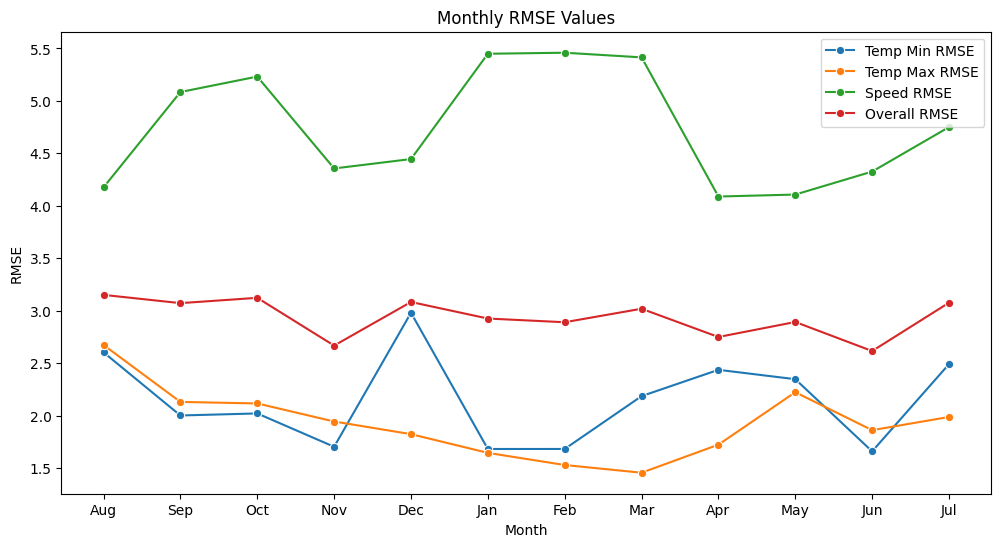

In [133]:
from utils.monthly_rmse import monthlyRmsePlot
monthlyRmsePlot(data_to_save)

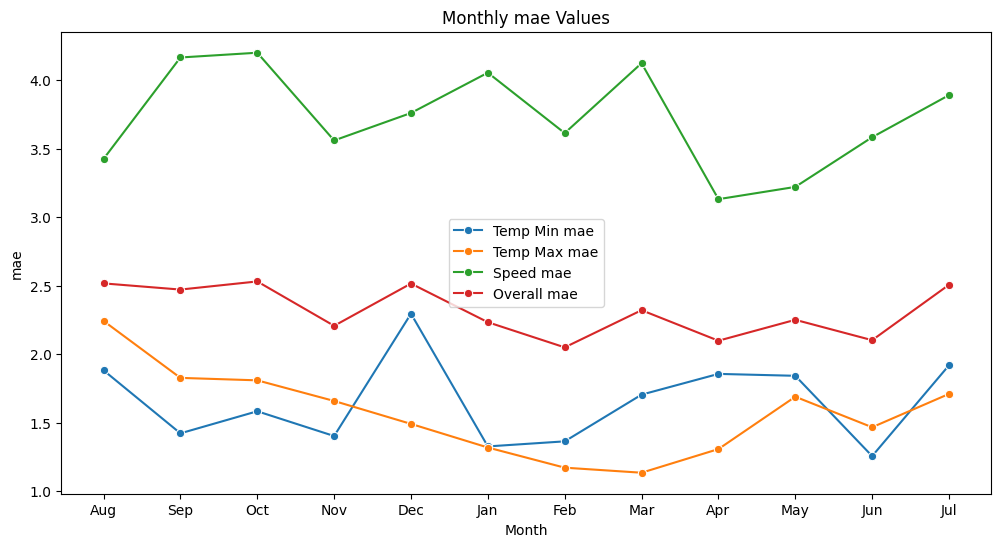

In [134]:
from utils.monthly_mae import monthlyMaePlot
monthlyMaePlot(data_to_save)

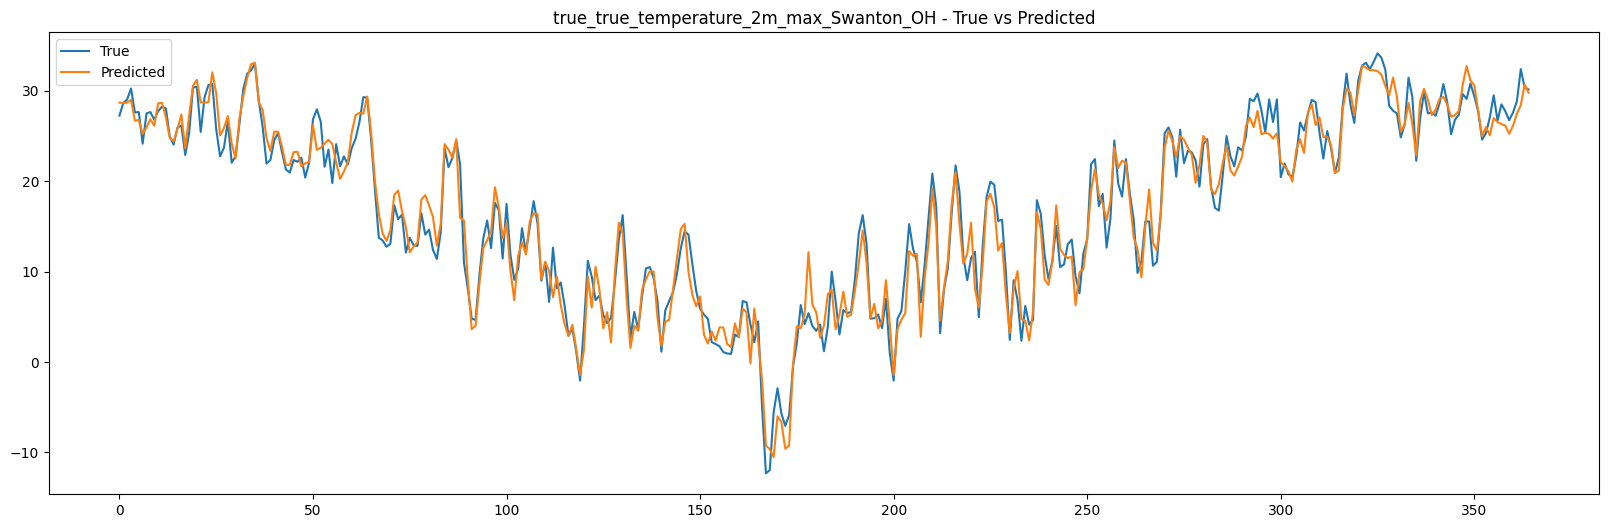

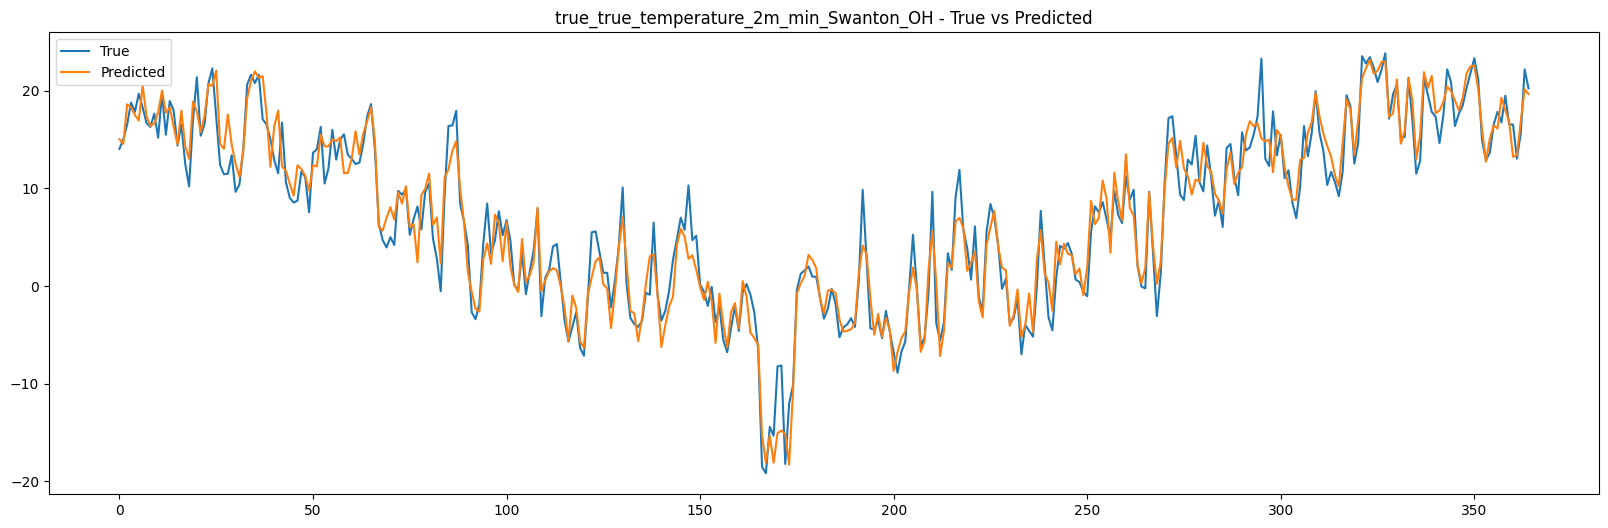

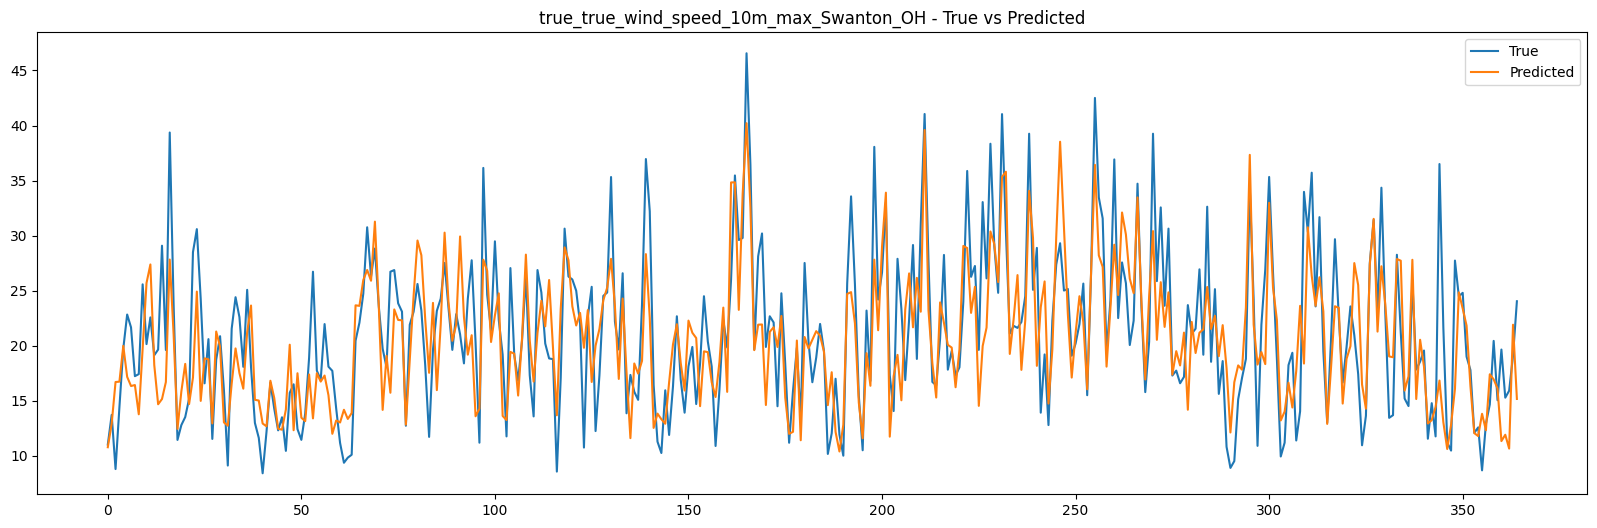

In [135]:
from enums.enums import Model, Date, Data, Rmse
from utils.create_plot import create_plot
create_plot(data_to_save[Data.TEST_OUTPUT_DATA].to_numpy(), data_to_save[Data.PREDICTED_OUTPUT_DATA], data_to_save[Data.TEST_OUTPUT_DATA].columns)